In [1]:
# Francisco Dominguez Mateos
# 03/08/2020
# SIREN for SDF in 2D
# added loss_sdf that is SIREN loss for sdf
# from:https://www.youtube.com/watch?v=Q5g3p9Zwjrk
#      https://vsitzmann.github.io/siren/

In [2]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jacrev, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import cv2
print("OpenCV v",cv2.__version__)

OpenCV v 4.3.0


In [3]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [4]:
def Siren(s=[1000]*5,omega_0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        print(len(keys))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))/omega_0
            w_key, b_key = random.split(rng)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=list(zip(sizes[:-1], sizes[1:], keys))
        params=[initialize_layer(m, n, k) for m, n, k in pairs[:]]
        # First layes scale is different
        m,n,k=pairs[0]
        w_key, b_key = random.split(k)
        scale=1.0/float(m)
        print("scale",m,n,scale)
        params[0]=scale*random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params[:-1]:
            linear = np.dot(w,activations)+b
            activations=np.sin(omega_0*linear)
        w,b=params[-1]
        linear= np.dot(w,activations)+b
        #return activations#.reshape(())
        return linear#.reshape(())
    return init_fun, apply_fun

In [5]:
# This function is needed because grad need a funtion with scalar as output, that is what a.reshape(()) does
# and Siren return a 1D np.array that grad doesn't like
def net_pre_grad(params,x):
    a=net(params,x)
    return a.reshape(())
def laplace(params,x):
    jac=jacrev(net_grad,1)
    return np.trace(jac(params,x))

In [38]:
init,net=Siren([256]*3+[1],6)
net_grad=grad(net_pre_grad,argnums=1)
net_lapl=laplace

input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(output_shape)
for l in params:
    print(l[0].shape,l[1].shape)

[2, 256, 256, 256, 1]
5
scale 2 256 0.5
(-1, 1)
(256, 2) (256,)
(256, 256) (256,)
(256, 256) (256,)
(1, 256) (1,)


In [39]:
net(params,np.array([0.5,0.5]))

DeviceArray([0.08366705], dtype=float32)

In [40]:
net_grad(params,np.array([0.5,0.5]))

DeviceArray([-0.12888514, -0.1948697 ], dtype=float32)

In [41]:
# Make a batched version of the `net` function
batch_net      = vmap(net     , in_axes=(None, 0), out_axes=0)
batch_net_grad = vmap(net_grad, in_axes=(None, 0), out_axes=0)
batch_net_lapl = vmap(net_lapl, in_axes=(None, 0), out_axes=0)

In [42]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_sdf(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width))

def build_sdf_grad(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net_grad(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,2))

In [43]:
sidelength=128

(16384, 2)
(16384, 1)
0.44982272 -0.24624793


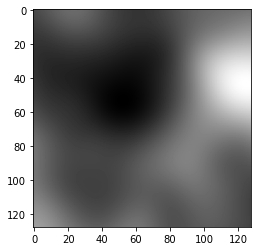

In [44]:
W=sidelength
H=sidelength
input_ordered=getInputOrdered((H,W))
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap='gray',)

In [45]:
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(16384, 2)
(16384, 2)
1.160018 -0.94647247


0.55068755 -0.4493125
(16384, 3)


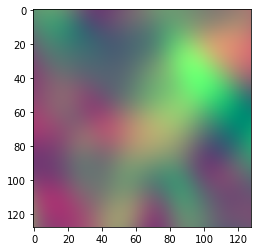

In [46]:
gsdf_values=img.reshape((-1,2))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))

In [47]:
@jit
def sdf_2d(point):
    x,y=point
    d0=x*x+y*y-0.30*0.30
    x1=x+0.3
    y1=y-0.3
    d1=x1*x1+y1*y1-0.15*0.15
    x2=x+0.3
    y2=y+0.3
    d2=x2*x2+y2*y2-0.15*0.15
    return np.min(np.array([d0,d1,d2]))
def points():
    pts=[]
    pts+=pointsCircle(0.0, 0.0,0.30)
    pts+=pointsCircle(0.3,-0.3,0.15)
    pts+=pointsCircle(0.3, 0.3,0.15)
    
gsdf_2d=grad(sdf_2d)

print( sdf_2d((0.2,0.2)))
print(gsdf_2d((0.2,0.2)))
#batch_sdf_2d =vmap( sdf_2d, in_axes=(None, 0), out_axes=0)
#batch_gsdf_2d=vmap(gsdf_2d, in_axes=(None, 0), out_axes=0)
batch_sdf_2d =vmap( sdf_2d)
batch_gsdf_2d=vmap(gsdf_2d)

-0.009999998
(DeviceArray(0.4, dtype=float32), DeviceArray(0.4, dtype=float32))


In [48]:
#mapped=list(map(sdf_2d,input_ordered))
mapped=batch_sdf_2d(input_ordered)
sdf_values=np.reshape(np.array(mapped),(-1,1))
print(sdf_values.shape)
s=np.max(sdf_values)-np.min(sdf_values)
sdf_values/=s
print(np.max(sdf_values),np.min(sdf_values))

(16384, 1)
0.9542914 -0.04570862


In [49]:
#gmapped=list(map(gsdf_2d,input_ordered))    
gmapped=batch_gsdf_2d(input_ordered)    
gsdf_values=np.reshape(np.array(gmapped),(-1,2))
print(gsdf_values.shape)

(16384, 2)


1.96875 -2.0
0.999876 -1.0157471
0.999876 -1.0157471


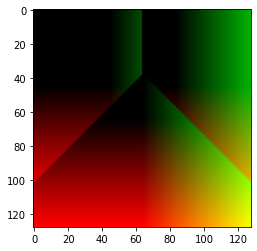

In [50]:
def getImgGrads(gsdf_values_gt):
    print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    gmax=np.max(gsdf_values_gt)
    gmin=np.min(gsdf_values_gt)
    d=gmax-gmin
    gsdf_values_gt/=s
    print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    #norms=np.linalg.norm(gsdf_values_gt,axis=1).reshape(-1,1)+0.0001
    #print("norms",norms.shape)
    #gsdf_values=gsdf_values_gt/norms
    print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    z=np.zeros((gsdf_values_gt.shape[0],1))
    v=np.hstack((gsdf_values_gt,z))
    img=np.reshape(v,(H,W,3))
    return img
img=getImgGrads(gsdf_values)
plt.imshow(img)

sdf_max 0.9542914
sdf_min -0.04570862


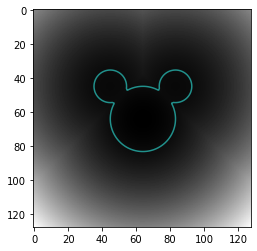

In [51]:
def drawContour(sdf_values):    
    img=np.reshape(sdf_values,(H,W))
    sdf_max=np.max(sdf_values)
    sdf_min=np.min(sdf_values)
    print("sdf_max",sdf_max)
    print("sdf_min",sdf_min)
    plt.imshow((img+1.0)/2.0,cmap="gray")
    cs=plt.contour(range(H),range(W),img,0)
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()
drawContour(sdf_values)

$$L_\Omega=\sum_\Omega|\phi(x)-d(x)|+||\nabla\phi(x)-n(x)||_2$$

In [52]:
@jit
def loss_sdf_easy(params,inputs,targets):
    values,normals=targets[:,0],targets[:,1:3]
    
    phi      = batch_net     (params, inputs)
    phi_grad = batch_net_grad(params,inputs)
    loss_d=(phi-values)**2
    loss_n=np.linalg.norm(phi_grad-normals,axis=1)
    loss=loss_d+0.1*loss_n
    return np.mean(loss)

In [53]:
@jit
def accuracy(params,inputs,targets):
    return loss_sdf_easy(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    #print("y=",len(y))
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_sdf_easy)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [21]:
print("input_ordered" ,input_ordered.shape)
print("sdf_values" ,sdf_values.shape)
print("gsdf_values",gsdf_values.shape)

idxb=np.abs(sdf_values)<0.01
idx0=np.where(idxb)[0]
print("idx0",idx0.shape)

points_insurface =input_ordered[idx0]
values_insurface =sdf_values[idx0]
normals_insurface=gsdf_values[idx0]
print("points_insurface" ,points_insurface.shape)
print("values_insurface" ,values_insurface.shape)
print("normals_insurface",normals_insurface.shape)

idxb=np.logical_not(idxb)
idx1=np.where(idxb)[0]
print("idx1",idx1.shape)
points_outsurface_all =input_ordered[idx1]
values_outsurface_all =sdf_values[idx1]
normals_outsurface_all=gsdf_values[idx1]

N=points_insurface.shape[0]



input_ordered (16384, 2)
sdf_values (16384, 1)
gsdf_values (16384, 2)
idx0 (1342,)
points_insurface (1342, 2)
values_insurface (1342, 1)
normals_insurface (1342, 2)
idx1 (15042,)


In [54]:
def buildData():
    idx=random.shuffle(rng,idx1)
    #print("idx1",idx1.shape)
    #print("idx",idx.shape)
    idxN=idx#[:N]
    points_outsurface =points_outsurface_all[idxN]
    values_outsurface =values_outsurface_all[idxN]
    normals_outsurface=normals_outsurface_all[idxN]
    #print("points_outsurface" ,points_outsurface.shape)
    #print("values_outsurface" ,values_outsurface.shape)
    #print("normals_outsurface",normals_outsurface.shape)

    x=np.vstack((points_insurface ,points_outsurface))
    v=np.vstack((values_insurface ,values_outsurface))
    n=np.vstack((normals_insurface,normals_outsurface))
    #print("x" ,x.shape)
    #print("v" ,v.shape)
    #print("n",n.shape)

    inputs=x
    targets=np.hstack((v,n))
    #print(inputs.shape)
    #print(targets.shape)    
    return inputs,targets
inputs,targets=buildData()
print(inputs.shape)
print(targets.shape)    


NameError: name 'idx1' is not defined

In [55]:
targets=np.hstack((sdf_values,gsdf_values))
print(sdf_values.shape)
print(gsdf_values.shape)
print(targets.shape)
print(input_ordered.shape)
inputs=input_ordered.copy()
loss_sdf_easy(params,input_ordered,targets)

(16384, 1)
(16384, 2)
(16384, 3)
(16384, 2)


DeviceArray(0.21212226, dtype=float32)

In [56]:
# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [57]:
num_epochs = 5000
steps_til_summary = num_epochs/5

In [58]:
def shuffle_data(x,y):
    #idx=random.randint(rng,x.shape[0],0,x.shape[0])
    #idx=onp.random.randint(0,x.shape[0])
    idx=random.shuffle(rng,np.arange(x.shape[0]))
    return x[idx],y[idx]
def run_training_loop(num_epochs, opt_state):
    global params
    #inputs,targets=buildData()
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        #inputs,targets=buildData()
        i,t=shuffle_data(inputs,targets)
        params, opt_state, loss = update(params, i,t, opt_state)
        train_loss.append(loss)

        if(epoch %steps_til_summary ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | loss: {:0.4f}".format(epoch+1, epoch_time,loss))
            img_pred =batch_net(params,inputs)
            img_grad =batch_net_grad(params,inputs)
            img_lapl =batch_net_lapl(params,inputs)
            
            fig, axes = plt.subplots(1,3, figsize=(18,6))
            axes[0].imshow(img_pred.reshape((sidelength,sidelength)))
            axes[1].imshow(np.linalg.norm(img_grad,axis=1).reshape((sidelength,sidelength)))
            axes[2].imshow(img_lapl.reshape((sidelength,sidelength)))
            plt.show()

    return opt_state, train_loss, log_acc_train, log_acc_test

Epoch 1 | T: 0.007 | loss: 0.1082


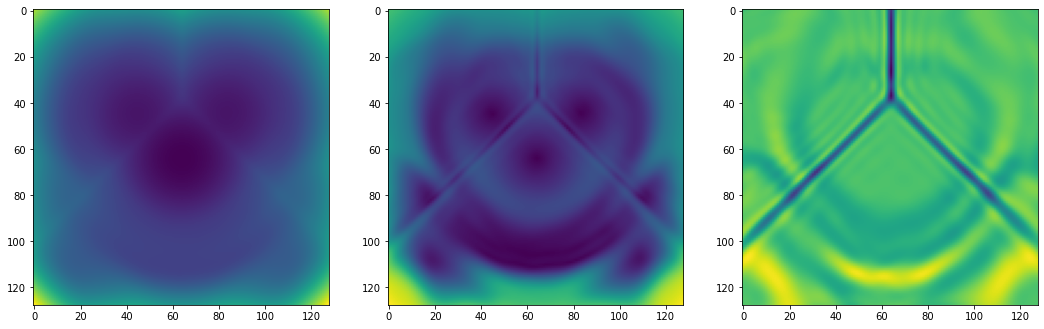

Epoch 1001 | T: 0.040 | loss: 0.1082


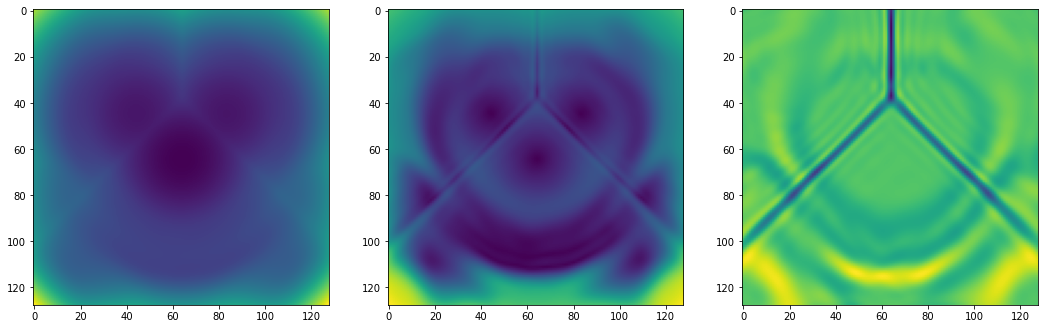

Epoch 2001 | T: 0.028 | loss: 0.1082


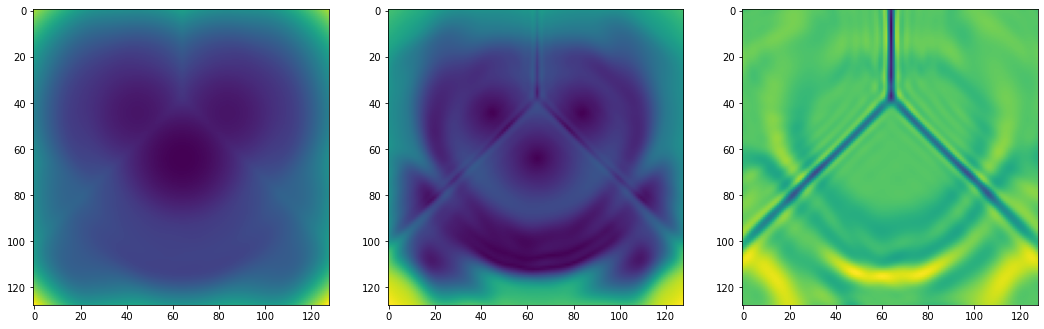

Epoch 3001 | T: 0.028 | loss: 0.1081


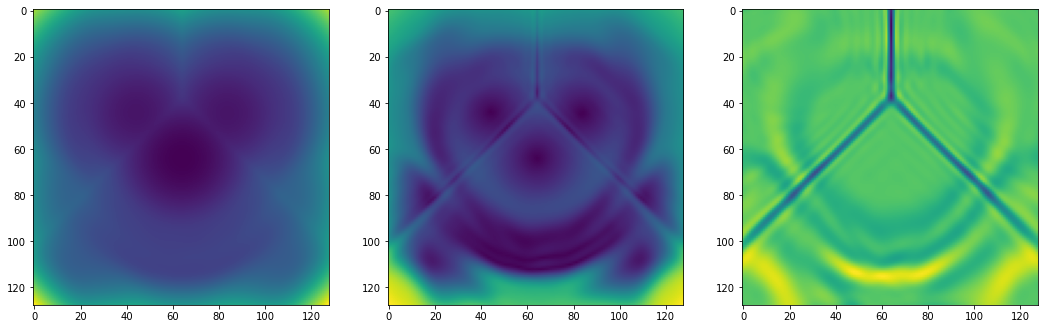

Epoch 4001 | T: 0.031 | loss: 0.1081


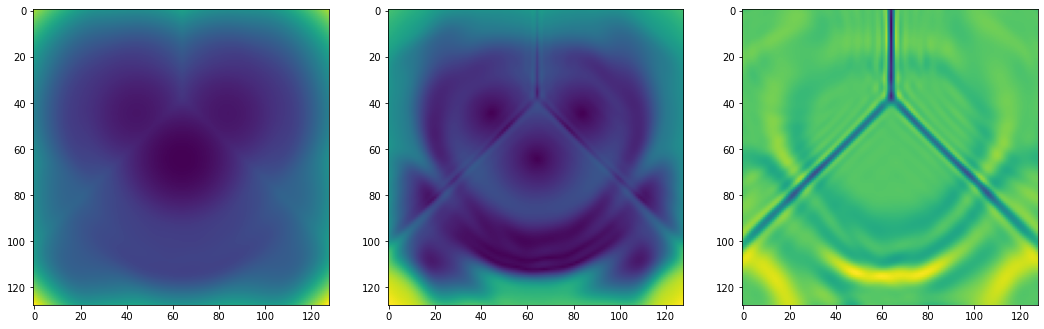

In [66]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

In [60]:
loss_sdf_easy(params,inputs,targets)

DeviceArray(0.10824309, dtype=float32)

(16384, 2)
(16384, 1)
0.9523807 -0.07726598


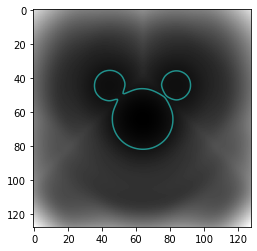

In [61]:
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap="gray")
cs=plt.contour(range(H),range(W),img,0)
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

In [62]:
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(16384, 2)
(16384, 2)
1.9889091 -2.0237463


0.49565908 -0.5043409
(16384, 3)


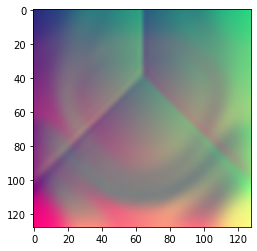

In [63]:
gsdf_values=img.reshape((-1,2))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))

1.9889091 -2.0237463
0.49565908 -0.5043409
0.49565908 -0.5043409


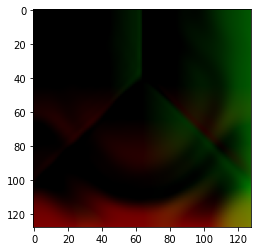

In [64]:
img_grad =batch_net_grad(params,inputs)
img=getImgGrads(img_grad)
plt.imshow(img)

In [65]:
net(params,np.array([0,0]))

DeviceArray([-0.07726579], dtype=float32)

In [39]:
net_grad(params,np.array([0.0,0.0]))

DeviceArray([-0.00494281,  0.00041988], dtype=float32)

In [35]:
(net(params,np.array([0.00001,0]))-net(params,np.array([0.,0])))/0.00001

DeviceArray([69.30232], dtype=float32)

In [36]:
(net(params,np.array([0.0,0.00001]))-net(params,np.array([0.0,0.0])))/0.00001

DeviceArray([59.568882], dtype=float32)